### Objective: To analyze the resuls of simulations. 

I previously, randomly generated a series of scoring functions to play 7x7 isolation.
In this I am looking at how these guys performed. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
from os import getcwd,listdir
from os.path import split, join
import sys
import random
from collections import namedtuple, OrderedDict
from tqdm import tqdm_notebook as pbar
# set the base path
base_path = split(getcwd())[0]
sys.path.append(base_path)


from isolation import Board
from sample_players import (RandomPlayer, open_move_score,
                            improved_score, center_score)
from game_agent import (MinimaxPlayer, AlphaBetaPlayer, custom_score,
                        custom_score_2, custom_score_3)

from tournament import *
from custom_builders import (exponent_score_builder, 
                             improved_weighted_center_score_builder,
                             improved_weighted_score_builder)
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns',999)

%matplotlib inline

In [2]:
def add_features(data): 
    data = data.copy()
    data['total games won'] = data.iloc[:,:7].sum(axis=1)
    data['total games lost'] = 7*20 - data['total games won']
    data['total games played'] = 7*20
    data['Win_Rate'] = np.round(data['total games won']*100.0/data['total games played'], 2)
    return data

In [3]:
data1 = pd.read_csv('GameSimulationResults.csv', index_col = 0, usecols=range(8))
data2 = pd.read_csv('GameSimulationResults2.csv', index_col=0, usecols=range(8))
data = pd.concat([add_features(data1), add_features(data2)])

### Normalize the win rates by the ab win rate. 
Because, I competd AB improved in 40 games, I know its win rate to a higher level of confindence. 

In [4]:
# First adjust the ab_improved by summing
ab_improved = data.loc['AB_Improved'].sum()
ab_improved = pd.DataFrame(ab_improved).T
ab_improved['Win_Rate'] = ab_improved['total games won']/ ab_improved['total games played']*100.0
ab_improved.index = ['AB_Improved']

# remove the ab row and append the new one
data = data.loc[data.index!='AB_Improved']
data = pd.concat([data, ab_improved])

# normalize
data['Relative Win Rate'] = data['Win_Rate']/data.loc['AB_Improved']['Win_Rate']
data =data.sort_values('Win_Rate', ascending=False)

### Parse the index string to extract the parameters. 

In [5]:
def parse_index_string(string):
    """ TO parse the index to get the features of interest"""
    string= string.replace('lamba', 'lambda')
    parts = string.split()
    param_dict = {'k': 0, 'w':1, 'lambda': 0, 'agent_type':parts}
    if len(parts)>1: 
        param_dict['agent_type'] = parts[0]
        parameters = parts[1]
        parameters = parameters.replace('(', '').replace(')','').split(',')
        for param in parameters: 

            param = param.split(':')
            param_dict[param[0]]=np.float(param[1])
    return pd.DataFrame(param_dict, index = [string])

In [6]:
parsed_index =pd.concat(map(parse_index_string, data.index))

In [7]:
index = data.index
data = pd.concat([data.reset_index(drop =True), parsed_index.reset_index(drop=True)], axis = 1)
data.index = index

In [8]:
data =data.rename_axis({'lambda':'Lambda'}, axis = 1)
data.head()

,AB_Center,AB_Improved,AB_Open,MM_Center,MM_Improved,MM_Open,Random,total games won,total games lost,total games played,Win_Rate,Relative Win Rate,agent_type,k,Lambda,w
"AB_WeightedCenter (w:8.249055,lamba:0.163261)",12.0,16.0,12.0,19.0,16.0,18.0,19.0,112.0,28.0,140.0,80.00,1.197861,AB_WeightedCenter,0.0,0.163261,8.249055
AB_WeightedImproved (w:2.268515),15.0,15.0,11.0,17.0,16.0,16.0,18.0,108.0,32.0,140.0,77.14,1.155037,AB_WeightedImproved,0.0,0.000000,2.268515
AB_WeightedImproved (w:0.989725),12.0,13.0,12.0,19.0,15.0,17.0,20.0,108.0,32.0,140.0,77.14,1.155037,AB_WeightedImproved,0.0,0.000000,0.989725
"AB_WeightedCenter (w:1.754518,lamba:0.228263)",13.0,12.0,12.0,18.0,17.0,15.0,20.0,107.0,33.0,140.0,76.43,1.144406,AB_WeightedCenter,0.0,0.228263,1.754518
"AB_WeightedCenter (w:1.824917,lamba:0.361789)",8.0,14.0,14.0,17.0,16.0,18.0,19.0,106.0,34.0,140.0,75.71,1.133626,AB_WeightedCenter,0.0,0.361789,1.824917


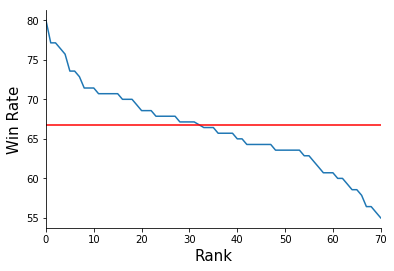

In [9]:
ax= data['Win_Rate'].reset_index(drop=True).plot()
ax.set_xlabel('Rank', size = 15)
ax.set_ylabel('Win Rate', size=15)
ax.axhline(ab_improved['Win_Rate'].values, color ='Red')
sns.despine()

### What is the win rate of the cpu agents
Below is the win rate for the cpu agents. 

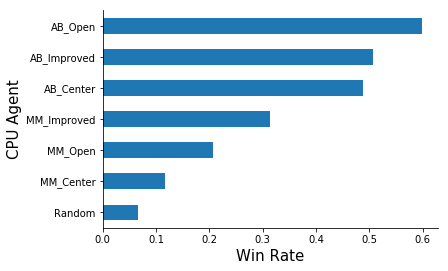

In [10]:
cpu_agents_win_rate= 1-data.iloc[:,:7].sum()/(len(data)*20)
ax=cpu_agents_win_rate.sort_values().plot.barh()
sns.despine()
ax.set_xlabel('Win Rate', size=15);
ax.set_ylabel('CPU Agent', size = 15)

In [11]:
cpu_agents_win_rate*100

AB_Center      48.873239
AB_Improved    50.774648
AB_Open        59.788732
MM_Center      11.760563
MM_Improved    31.338028
MM_Open        20.633803
Random          6.619718
dtype: float64

Overall, Alpha beta with iteratie deeping does a much better job than the minimax algo. Surprisingly AB open is more effective than AB Improved. These agents have a lower win rate than the agents that I tested because they are fighting tougher agents. 

In [12]:
against_ab=100-data.loc['AB_Improved'].iloc[:7]*100.0/40
against_ab.sort_values()


Random           10
MM_Center      17.5
MM_Open        27.5
MM_Improved    32.5
AB_Center        45
AB_Improved    47.5
AB_Open        52.5
Name: AB_Improved, dtype: object

Above I am looking at the win rate of the 

### Make some graph to understand the trends. 

Look at the three groups alone as a function of the parameters. 

### Evaluate the Scaled Improved score. 

In [13]:
improved= data.query('agent_type =="AB_WeightedImproved"').copy()

How does does the Win rate vary as a function of the weight parameter? 

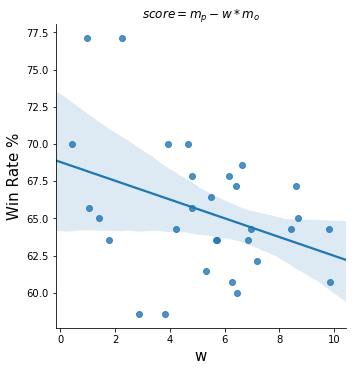

In [14]:
sns.lmplot(data = improved, x = 'w',y='Win_Rate')
ax = plt.gca()
ax.set_xlabel('w', size = 15)
ax.set_ylabel('Win Rate %', size =15)
ax.set_title(r'$score = m_p - w*m_o$');


In [15]:
results = smf.ols('Win_Rate~ w', data = improved).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               Win_Rate   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     4.398
Date:                Sun, 26 Nov 2017   Prob (F-statistic):             0.0451
Time:                        11:48:19   Log-Likelihood:                -84.805
No. Observations:                  30   AIC:                             173.6
Df Residuals:                      28   BIC:                             176.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     68.7872      1.758     39.133      0.0

Although I am not evaluating the fit to closely, there is a statiistically 'significant' relationship between the w and the Win Rate. As per the OLS fit above, y = 68.8 -0.6305 * w. As we increase w, we decrease the win rate. 

### Evaluate the Improved weighted centered score win rate as above. 

In [16]:
centered = data.query('agent_type =="AB_WeightedCenter"').copy()

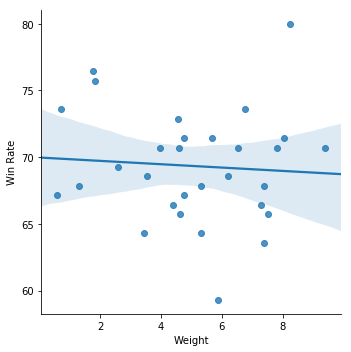

In [17]:
sns.lmplot(data = centered, x = 'w',y='Win_Rate')
ax = plt.gca()
ax.set_xlabel('Weight')
ax.set_ylabel('Win Rate')

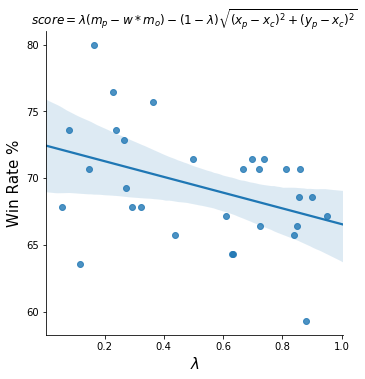

In [18]:
sns.lmplot(data = centered, x = 'Lambda',y='Win_Rate')
ax = plt.gca()
ax.set_xlabel(r'$\lambda$', size = 15)
ax.set_ylabel('Win Rate %', size = 15)
ax.set_title(r'$score = \lambda(m_p - w*m_o) - (1-\lambda)\sqrt{(x_p-x_c)^2+(y_p-x_c)^2}$')

In [19]:
results = smf.ols('Win_Rate~ Lambda + w', data = centered).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               Win_Rate   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     2.640
Date:                Sun, 26 Nov 2017   Prob (F-statistic):             0.0897
Time:                        11:48:20   Log-Likelihood:                -82.712
No. Observations:                  30   AIC:                             171.4
Df Residuals:                      27   BIC:                             175.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     72.5753      2.103     34.511      0.0

### Comments
As per the regression and plots above, it appear that for the agents that use a score function of score = difference between player moves and distance from center that the only center distance matters. The score decreases as a function of the lambda. 

I will not explore the exponential explicitily as it is poor performer. 

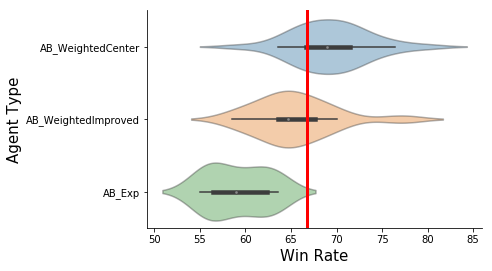

In [20]:
ax =sns.violinplot(x = 'Win_Rate', y= 'agent_type', data = data.query('agent_type!="AB_Improved"'))
ax.set_ylabel('Agent Type', fontsize= 15)
ax.set_xlabel('Win Rate', fontsize = 15)
plt.setp(ax.collections, alpha=.4)
sns.despine()
ax.axvline(data.loc['AB_Improved']['Win_Rate'],color='Red', linewidth=3);

### One last thing: How correlated is the behavior of the agents? 

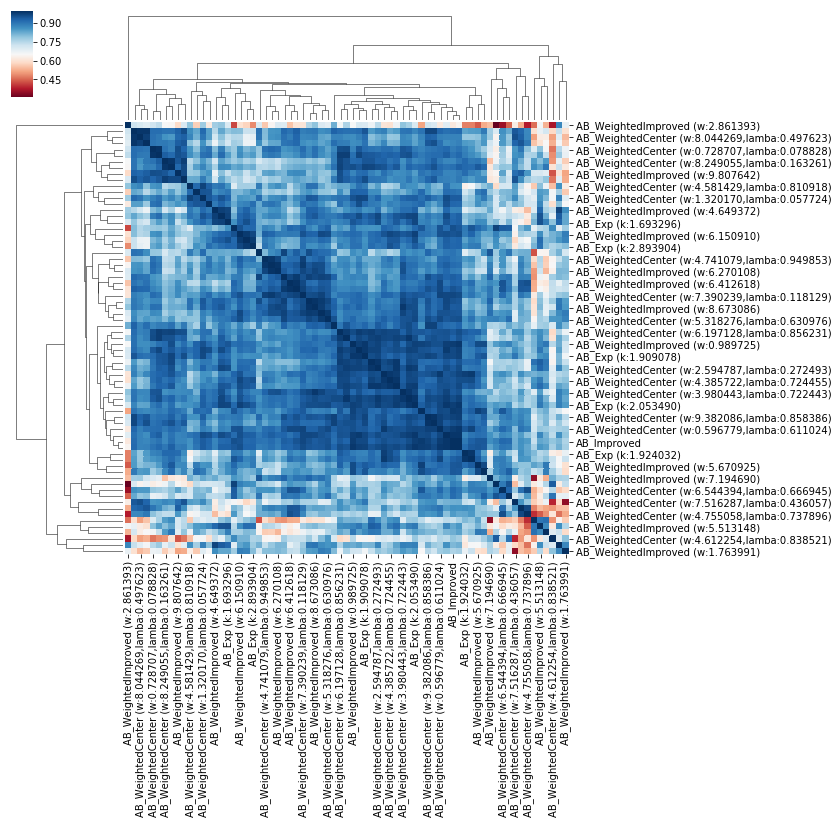

In [21]:
correlation = data.iloc[:, :7].T.corr()
sns.clustermap(correlation, cmap ='RdBu')

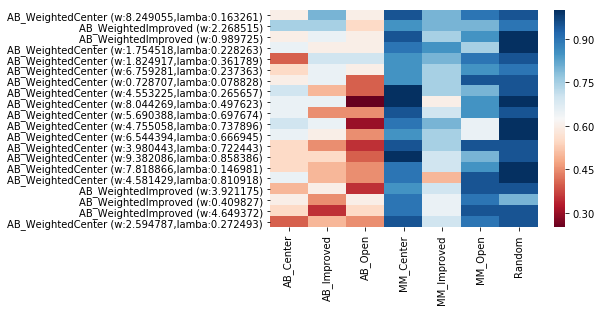

In [22]:
sns.heatmap(data.head(20).iloc[:,:7]/20, cmap='RdBu');

### Running one last tournament with our best players. 

In [23]:
data.iloc[:3,-3::]

,k,Lambda,w
"AB_WeightedCenter (w:8.249055,lamba:0.163261)",0.0,0.163261,8.249055
AB_WeightedImproved (w:2.268515),0.0,0.000000,2.268515
AB_WeightedImproved (w:0.989725),0.0,0.000000,0.989725


In [24]:
def main():
    # Define two agents to compare -- these agents will play from the same
    # starting position against the same adversaries in the tournament
    test_agents = [
        Agent(AlphaBetaPlayer(score_fn=improved_score), "AB_Improved"),
        Agent(AlphaBetaPlayer(score_fn=improved_weighted_center_score_builder(8.25, .16)), "Agent1"),
        Agent(AlphaBetaPlayer(score_fn=improved_weighted_score_builder(2.27)), "Agent2"),
        Agent(AlphaBetaPlayer(score_fn=improved_weighted_score_builder(0.99)), "Agent3")
    ]

    # Define a collection of agents to compete against the test agents
    cpu_agents = [
        Agent(RandomPlayer(), "Random"),
        Agent(MinimaxPlayer(score_fn=open_move_score), "MM_Open"),
        Agent(MinimaxPlayer(score_fn=center_score), "MM_Center"),
        Agent(MinimaxPlayer(score_fn=improved_score), "MM_Improved"),
        Agent(AlphaBetaPlayer(score_fn=open_move_score), "AB_Open"),
        Agent(AlphaBetaPlayer(score_fn=center_score), "AB_Center"),
        Agent(AlphaBetaPlayer(score_fn=improved_score), "AB_Improved")
    ]
    print(DESCRIPTION)
    print("{:^74}".format("*************************"))
    print("{:^74}".format("Playing Matches"))
    print("{:^74}".format("*************************"))
    play_matches(cpu_agents, test_agents, 5)


In [25]:
main()


This script evaluates the performance of the custom_score evaluation
function against a baseline agent using alpha-beta search and iterative
deepening (ID) called `AB_Improved`. The three `AB_Custom` agents use
ID and alpha-beta search with the custom_score functions defined in
game_agent.py.

                        *************************                         
                             Playing Matches                              
                        *************************                         

 Match #   Opponent    AB_Improved    Agent1       Agent2       Agent3    
                        Won | Lost   Won | Lost   Won | Lost   Won | Lost 
    1       Random       9  |   1     7  |   3    10  |   0    10  |   0  
    2       MM_Open      7  |   3     7  |   3     7  |   3    10  |   0  
    3      MM_Center     9  |   1     9  |   1     9  |   1     9  |   1  
    4     MM_Improved    6  |   4     4  |   6     9  |   1     7  |   3  
    5       AB_Open      4  

In [26]:
agent1 = Agent(AlphaBetaPlayer(score_fn=improved_score), "AB_Improved")
agent2 = Agent(AlphaBetaPlayer(score_fn=improved_weighted_center_score_builder(8.25, .16)), "Custom1")
agents={agent1.player:agent1.name,agent2.player:agent2.name}

In [27]:
moves= []
winners = []
reasons = []
for _ in pbar(range(100)):
    game = Board(agent1.player, agent2.player)
    winner, m, reason=game.play(time_limit=150)
    moves.append(m)
    reasons.append(reason)
    winners.append(agents[winner])
    
    game = Board(agent2.player, agent1.player)
    winner, m, reason=game.play(time_limit=150)
    moves.append(m)
    reasons.append(reason)
    winners.append(agents[winner])
    

    

In [28]:
res=pd.Series(winners).value_counts()
res/200

Custom1        0.68
AB_Improved    0.32
dtype: float64

In [29]:
pd.Series(reasons).value_counts()

illegal move    200
dtype: int64

In [30]:
i=3
print(winners[i])
moves[i]

Custom1


[[2, 1],
 [1, 0],
 [3, 3],
 [3, 1],
 [2, 5],
 [1, 2],
 [0, 4],
 [2, 0],
 [1, 6],
 [3, 2],
 [3, 5],
 [5, 3],
 [4, 3],
 [3, 4],
 [2, 4],
 [4, 2],
 [3, 6],
 [2, 3],
 [4, 4],
 [0, 2],
 [6, 5],
 [1, 4],
 [4, 6],
 [2, 6],
 [5, 4],
 [0, 5],
 [6, 2],
 [1, 3],
 [4, 1],
 [0, 1],
 [2, 2]]

### What is the typical first move by the players? 

In [31]:
custom_first_moves= pd.Series([moves[i][0] for i in range(1,200,2)])
custom_second_moves= pd.Series([moves[i][1] for i in range(0,200,2)])
ab_first_moves = pd.Series([moves[i][0] for i in range(0,200,2)])
ab_second_moves = pd.Series([moves[i][1] for i in range(1,200,2)])

In [32]:
print(custom_first_moves.astype(str).value_counts())
print(custom_second_moves.astype(str).value_counts())

[2, 1]    100
dtype: int64
[2, 1]    100
dtype: int64


In [33]:
print(ab_first_moves.astype(str).value_counts())
print(ab_second_moves.astype(str).value_counts())

[2, 2]    100
dtype: int64
[1, 0]    100
dtype: int64


So the AB_custom agent will start at (2,2) if it is the first player, and will start at (1,0) if it is the second player. Where as the custom agent 1 will always start at (2,1) if given the chance. This might just be a stronger position? 

In [34]:
data['Win_Rate'].head()

AB_WeightedCenter (w:8.249055,lamba:0.163261)    80.00
AB_WeightedImproved (w:2.268515)                 77.14
AB_WeightedImproved (w:0.989725)                 77.14
AB_WeightedCenter (w:1.754518,lamba:0.228263)    76.43
AB_WeightedCenter (w:1.824917,lamba:0.361789)    75.71
Name: Win_Rate, dtype: float64

In [35]:
ab_improved['Win_Rate']

AB_Improved    66.785714
Name: Win_Rate, dtype: float64

### Who is the best exponential player. 
As part of my review it seemed that they wanted to see my exponential player. I will put that into the report. 

In [36]:
data.loc[data.index.str.startswith('AB_Exp')].head(3)

,AB_Center,AB_Improved,AB_Open,MM_Center,MM_Improved,MM_Open,Random,total games won,total games lost,total games played,Win_Rate,Relative Win Rate,agent_type,k,Lambda,w
AB_Exp (k:2.038002),9.0,10.0,8.0,16.0,12.0,16.0,18.0,89.0,51.0,140.0,63.57,0.951850,AB_Exp,2.038002,0.0,1.0
AB_Exp (k:1.924032),7.0,11.0,6.0,16.0,16.0,14.0,18.0,88.0,52.0,140.0,62.86,0.941219,AB_Exp,1.924032,0.0,1.0
AB_Exp (k:1.918639),8.0,8.0,6.0,18.0,13.0,15.0,20.0,88.0,52.0,140.0,62.86,0.941219,AB_Exp,1.918639,0.0,1.0


The best exponential player has a win rate of 63.57% and a Relative Win Rate of 0.95 relative to AB_improved agent. 
Its exponent was 2.04. I will have it as the third custome agent. 